In [1]:
%pip install --user --proxy http://proxy:80 -q transformers
%pip install --user --proxy http://proxy:80 -q datasets
%pip install --user --proxy http://proxy:80 -q monai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install --user --proxy http://proxy:80 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 5.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.1 MB/s eta 0:00:0000:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


## Configs

In [2]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import datetime

CONFIGS={
    "loss":'multiclass',
    "project":"Orange Segmentation",
    "activation":"softmax2d",
    "name":f"focal_{datetime.datetime.now().date()}",
    "height" : 416 ,
    "train_size":0.8, #used for train/test split
    "epoch" : 100,
    "width" : 192,
    "encoder" : "resnet18",
    "batch_size" : 64,
     "learning_rate" : 0.00001,
    "shuffle_seed" : 100,
    "description":"Let's try this settings first.",
    'data_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/Orange_Image_Data/Orange_Image_Data',
    'labels_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/project-4-at-2024-03-02-15-13-497758b6.json',
    'train_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation//train_res',
    'model_path':  '/home/hpc/rlvl/rlvl102h/train_res/default_model.pth',#'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/DiceLoss_2024-07-29/checkpoint_18.pth','/home/hpc/rlvl/rlvl102h/train_res/default_model.pth',
    'start_epoch':0,
    'max_data_samples':-1
    
}

/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/urllib/request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/http/client.py", line 1282, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/http/client.py", line 1328, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/http/client.py", line 1277, in endheaders
    self._send_output(message_body, encode_chunked=encode_c

In [1]:
import torch
torch.cuda.is_available()

True

### Subplots

In [3]:
import torch
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Optional
def subplot_images(
    images: List[np.ndarray],
    titles: Optional[List[str]] = None,
    fig_size: tuple = (20, 10),
    dpi: int = 100,
    cmap: str = "gray",
    order: Tuple[int, int] = (1, -1),
) -> plt.Figure:
    """
    Subplot multiple images using matplotlib.

    Parameters:
        images (List[np.ndarray]): List of images to be plotted.
        titles (Optional[List[str]]): List of titles for the images. Default is None.
        fig_size (tuple): Figure size for the plot. Default is (20, 10).
        dpi (int): Dots per inch for the plot. Default is 100.
        cmap (str): Colormap to be used for the images. Default is 'gray'.
        order (Tuple[int, int]): Order of subplots (rows, columns). Use -1 to auto-calculate one dimension.

    Returns:
        plt.Figure: The matplotlib Figure object.
    """
    # Calculate subplot grid dimensions if one is set to -1
    if order[1] == -1:
        order = (order[0], (len(images) + order[0] - 1) // order[0])
    elif order[0] == -1:
        order = ((len(images) + order[1] - 1) // order[1], order[1])

    fig, axes = plt.subplots(order[0], order[1], figsize=fig_size, dpi=dpi)
    plt.tight_layout()

    # Flatten axes array for easy iteration, handling the case where axes is not 2D
    if order[0] == 1 or order[1] == 1:
        axes = np.atleast_1d(axes).flatten()
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.axis("off")
            if titles:
                ax.set_title(titles[i], fontsize=12)
        else:
            ax.axis("off")  # Turn off axes for empty subplots

    plt.show()
    return fig


def show(
    image: np.ndarray, fig_size: tuple = (10, 10), cmap: str = "gray", title: str = None
):
    """
    Display an image using matplotlib.
    """
    plt.figure(figsize=fig_size)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

In [4]:
from transformers import SamProcessor, SamImageProcessor 
import os

config_path='/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/preprocessor_config.json'
img_processor = SamImageProcessor.from_pretrained(config_path)
processor = SamProcessor(img_processor)


ModuleNotFoundError: No module named 'transformers'

## Datasets

In [5]:


class DataLabels:
    def __init__(self, root_dir, labels_file, shuffle_seed=42, split_ratio=0.8, max_samples=-1):
        """
        root_dir: From where all dataset is being read.
        labels_file: Labels file path.
        shuffle_seed: to handle random split.
        split_ratio: first half train, second will be test
        max_samples: max number of samples to take. -1 means all.
        """
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.images_dir = root_dir
        self.shuffle_seed = shuffle_seed
        self.split_ratio = split_ratio
        self.max_samples = max_samples

        
        self.labels, self.label_counts = self.load_labels(labels_file)
        np.random.seed(shuffle_seed)
        fnames = list(self.labels.keys())
        np.random.shuffle(fnames)
        self.idxs = list(range(len(fnames)))
        self.labels = {k: self.labels[k] for k in fnames}
        self.train_idx = self.idxs[:int(len(self.labels) * split_ratio)]
        self.valid_idx = self.idxs[len(self.train_idx):]
        self.train_labels = {fnames[k]: self.labels[fnames[k]] for k in self.train_idx}
        self.valid_labels = {fnames[k]: self.labels[fnames[k]] for k in self.valid_idx}

    def load_labels(self, labels_dir):
        # Load segmentation labels from JSON file
        with open(labels_dir, 'r') as f:
            segmentation_data = json.load(f)

        final_labels = {}
        label_counts = {}
        self.label_names = []
        img_cnts = 0

        for sm in segmentation_data:
            img_name = "IMG" + sm['image'].split('-IMG')[1]
            img_dict = {}

            if sm.get('label') is None:
                continue

            for labels in sm['label']:
                width = labels['original_width']
                height = labels['original_height']
                points = np.array(labels['points']).reshape(-1, 2)
                points[:, 0] = points[:, 0] * width / 100
                points[:, 1] = points[:, 1] * height / 100

                label_names = labels['polygonlabels']

                for label_name in label_names:
                    self.label_names.append(label_name)
                    if img_dict.get(label_name) is None:
                        img_dict[label_name] = []
                    img_dict[label_name].append(points)

            final_labels[img_name] = img_dict
            label_counts[img_name] = {k: len(v) for k, v in img_dict.items()}
            img_cnts += 1
            
            if img_cnts >= self.max_samples and self.max_samples > 0:
                break

        self.label_names = sorted(list(set(self.label_names)))
        return final_labels, label_counts

class SAMDataSet(Dataset):
    def __init__(self, kind=1, data_labels=None,
                 color_space="RGB",  processor=None, pad_boxes=False, num_boxes=15, for_loader=False):
        """
        kind: 1 for training and 0 for validation.
        data_labels: dictionary containing labels.
        transform: what transformation to apply.
        color_space: rgb/hsv or any other.
        multiclass: if True, target will be N,H,W else, N,C,H,W
        """
        self.data_labels = data_labels
        self.color_space=color_space
        self.processor=processor
        self.pad_boxes=pad_boxes
        self.num_boxes=num_boxes
        self.for_loader=for_loader
        # 1 for train, 0 for valid
        if kind == 1:
            self.curr_labels = self.data_labels.train_labels
        else:
            self.curr_labels = self.data_labels.valid_labels

    def __len__(self):
        return len(self.curr_labels)

    def __getitem__(self, idx):
        img_name = list(self.curr_labels.keys())[idx]
        img_path = os.path.join(self.data_labels.images_dir, img_name)

        # Load image
        image = Image.open(img_path).convert(self.color_space)
        # image = image.resize((self.width, self.height))
        img_arr = np.array(image)
        h,w = img_arr.shape[:2]
        default_boxes = [[0,0,w,h] for _ in range(self.num_boxes)]
        
        
        # Create masks for each class label
        background = np.zeros(img_arr.shape[:2], dtype=np.uint8) + 255
        healthy = np.zeros(img_arr.shape[:2], dtype=np.uint8)
        infected = np.zeros(img_arr.shape[:2], dtype=np.uint8)

        masks_dict = {"Background": background, "Healthy": healthy, "Infected": infected}
        bb_dict={k:[] for k in masks_dict.keys()}

        bboxes = []
        for label_name, points_list in self.curr_labels[img_name].items():
            mask = masks_dict.get(label_name)

            # Draw each mask on the blank mask
            for points in points_list:
                points = np.round(points).astype(int)
                mask = cv2.fillPoly(mask, [points], 255)
                bounding_rect = cv2.boundingRect(points)
                background = cv2.fillPoly(background, [points], 0)
                bb_dict[label_name].append(bounding_rect)
                x, y, w, h= bounding_rect
                bboxes.append([x, y, x+w, y+h])

            masks_dict[label_name] = mask
        background = background

        masks = np.zeros((img_arr.shape[0], img_arr.shape[1], 3), dtype=np.uint8)
        masks[:, :, 0] = masks_dict["Background"]
        masks[:, :, 1] = masks_dict["Healthy"]
        masks[:, :, 2] = masks_dict["Infected"]

        if self.pad_boxes:
            bboxes += default_boxes[len(bboxes):]
        
        inputs = self.processor(image, input_boxes=[bboxes], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['ground_truth_mask'] = 255-masks_dict['Background']
        inputs['img_name']=img_name
        inputs['orig_img'] = img_arr
        # bcz its what model returns
        inputs['resized_ground_truth_mask'] = cv2.resize(inputs['ground_truth_mask'], (256,256))
        
        if self.for_loader:
            del inputs['img_name']
            del inputs['orig_img']
            del inputs['ground_truth_mask']
        # print(inputs)
        return inputs
# dataset and dataloader
data_labels = DataLabels(root_dir=CONFIGS['data_dir'], 
                         labels_file=CONFIGS['labels_dir'], 
                         split_ratio=CONFIGS['train_size'],
                        max_samples=-100,
                        shuffle_seed=CONFIGS['shuffle_seed'])


train_dataset = SAMDataSet(kind=1, data_labels=data_labels,processor=processor)
test_dataset = SAMDataSet(kind=0, data_labels=data_labels,processor=processor)

example = test_dataset[0]
for k,v in example.items():
    try:
        print(k,v.shape)
    except:
        pass

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([2, 4])
ground_truth_mask (4160, 1872)
orig_img (4160, 1872, 3)
resized_ground_truth_mask (256, 256)


In [6]:

tdl = DataLoader(SAMDataSet(kind=0, data_labels=data_labels,processor=processor, pad_boxes=True, for_loader=True), batch_size=2, num_workers=2, shuffle=True)

for batch in tdl:
    print(batch['pixel_values'].shape)
    break

torch.Size([2, 3, 1024, 1024])


## HF Model

In [7]:
from transformers import SamModel

model = SamModel.from_pretrained(pretrained_model_name_or_path ="/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/",
                                 cache_dir="/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/",
                                 local_files_only=True)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

/home/hpc/rlvl/rlvl102h/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
from PIL import Image

In [9]:
image=Image.open('/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/Orange_Image_Data/Orange_Image_Data/IMG_20230829_151128_100.jpg')

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [11]:
image.height,image.width

(4160, 1872)

In [12]:
inputs=processor(image, #input_boxes=[[[500,1000,1500,2000], [1200,1500,2000,3000]]], 
                 return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])


In [13]:

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

In [14]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores
masks[0][0].squeeze(0), scores

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[[0.1630]]], device='cuda:0'))

In [15]:
outputs.pred_masks.shape

torch.Size([1, 1, 1, 256, 256])

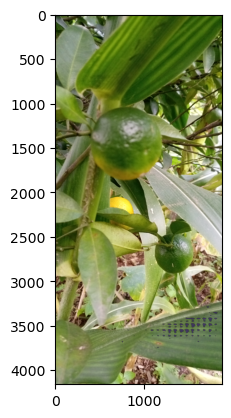

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        # print(mask.shape)
        show_mask(mask.sum(axis=0), ax=ax, random_color=True)
    # plt.axis("off")
    plt.show()
    del mask
    gc.collect()
    
show_masks_on_image(image, masks)

## SAM on Test Datasets

## BatchWise

In [17]:

# from tqdm import tqdm
# from statistics import mean
# import torch

# from torch.optim import Adam
# import monai


# def iou_score(predicted_mask, ground_truth_mask):
#     intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
#     union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
#     iou = (intersection + 1e-6) / (union + 1e-6)
#     return iou.mean().item()

# # Note: Hyperparameter tuning could improve performance here
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# num_epochs = 100

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.eval()
# ious={}

# best_iou = 0
# worst_iou=1
# best_iou_img = None
# worst_iou_img=None

# for inputs in tqdm(DataLoader(SAMDataSet(kind=0, data_labels=data_labels,processor=processor, pad_boxes=True, for_loader=True), batch_size=2, num_workers=2)):
#     outputs = model(pixel_values=inputs["pixel_values"].to(device),
#                     input_boxes=inputs["input_boxes"].to(device),
#                     multimask_output=False)
#     # compute loss
    

In [18]:
outputs.pred_masks.shape

torch.Size([1, 1, 1, 256, 256])

## No Batch

In [19]:
from tqdm import tqdm
from statistics import mean
import torch
import time

def iou_score(predicted_mask, ground_truth_mask):
    intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
    union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def zeroshot_sam(model, sam_dataset, device, use_points=False):
    best_iou = 0
    worst_iou=1
    best_iou_img = None
    worst_iou_img=None
    ious={}
    times = []
    for inputs in tqdm(sam_dataset):
        t0=time.perf_counter()
        if use_points:
            points = []
            for box in inputs["input_boxes"]:
                xc=(box[0]+box[2])//2
                yc=(box[1]+box[3])//2
                points.append([xc,yc])
            points = torch.tensor([points])
            outputs = model(pixel_values=inputs["pixel_values"].unsqueeze(0).to(device),
                            # input_boxes=inputs["input_boxes"].unsqueeze(0).to(device),
                            input_points = points.unsqueeze(0).to(device),
                            multimask_output=False)
        else:
            outputs = model(pixel_values=inputs["pixel_values"].unsqueeze(0).to(device),
                            input_boxes=inputs["input_boxes"].unsqueeze(0).to(device),
                            multimask_output=False)
        # compute loss
        ground_truth_masks = inputs["ground_truth_mask"]==255
        masks=processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                                                            inputs["original_sizes"].cpu().unsqueeze(0), 
                                                            inputs["reshaped_input_sizes"].cpu().unsqueeze(0))
        pred_mask = (masks[0].sum(axis=0)==1).squeeze(0)
        iou1 = iou_score(pred_mask, torch.from_numpy(ground_truth_masks))
        
        if  iou1>0.01 and iou1>best_iou:
            best_iou = iou1
            best_iou_img = [inputs['orig_img'], ground_truth_masks, pred_mask.numpy()]
        if iou1>0.01 and iou1<worst_iou:
            worst_iou = iou1
            worst_iou_img = [inputs['orig_img'], ground_truth_masks, pred_mask.numpy()]
        ious[inputs['img_name']]=iou1
        t1=time.perf_counter()
        times.append(t1-t0)
      
    
    return ious, best_iou, worst_iou, best_iou_img, worst_iou_img, times

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [03:33<00:00,  1.40it/s]


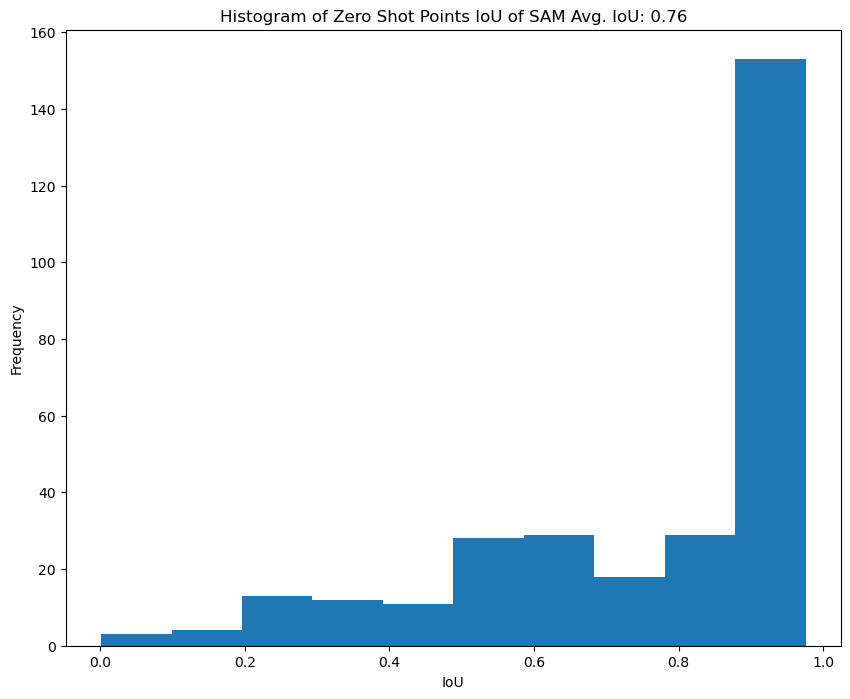

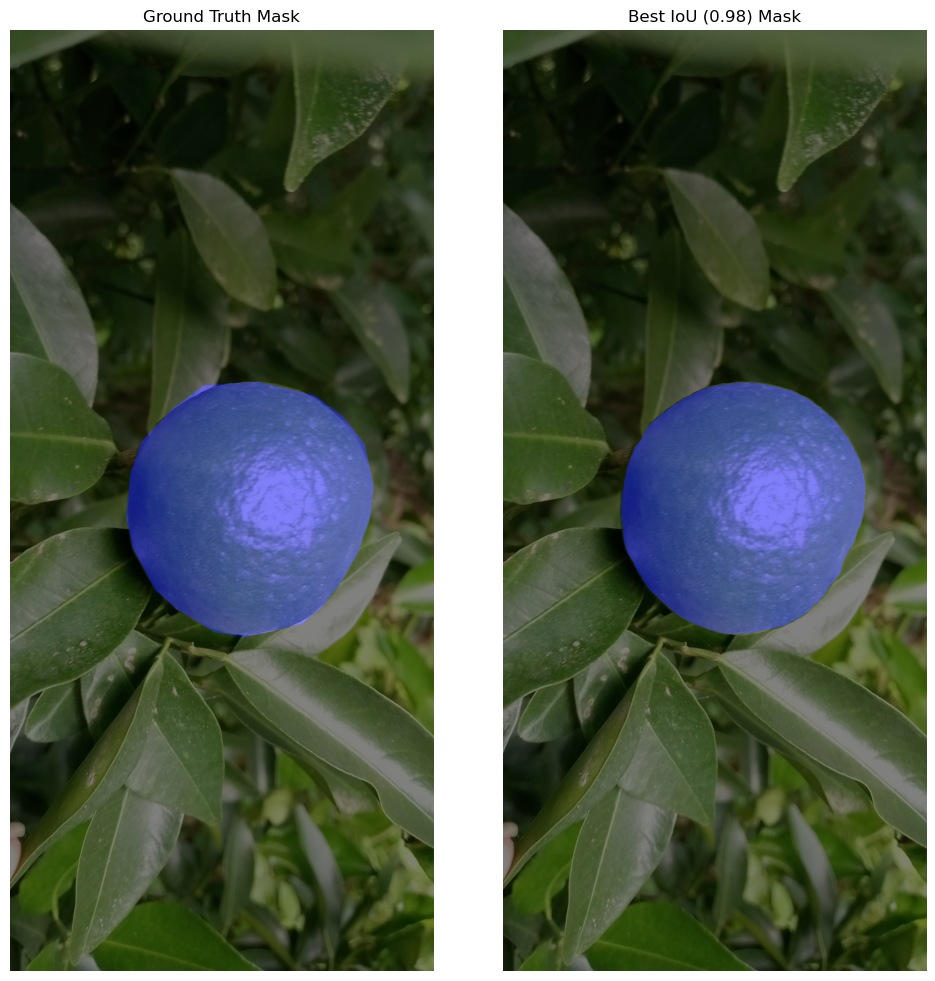

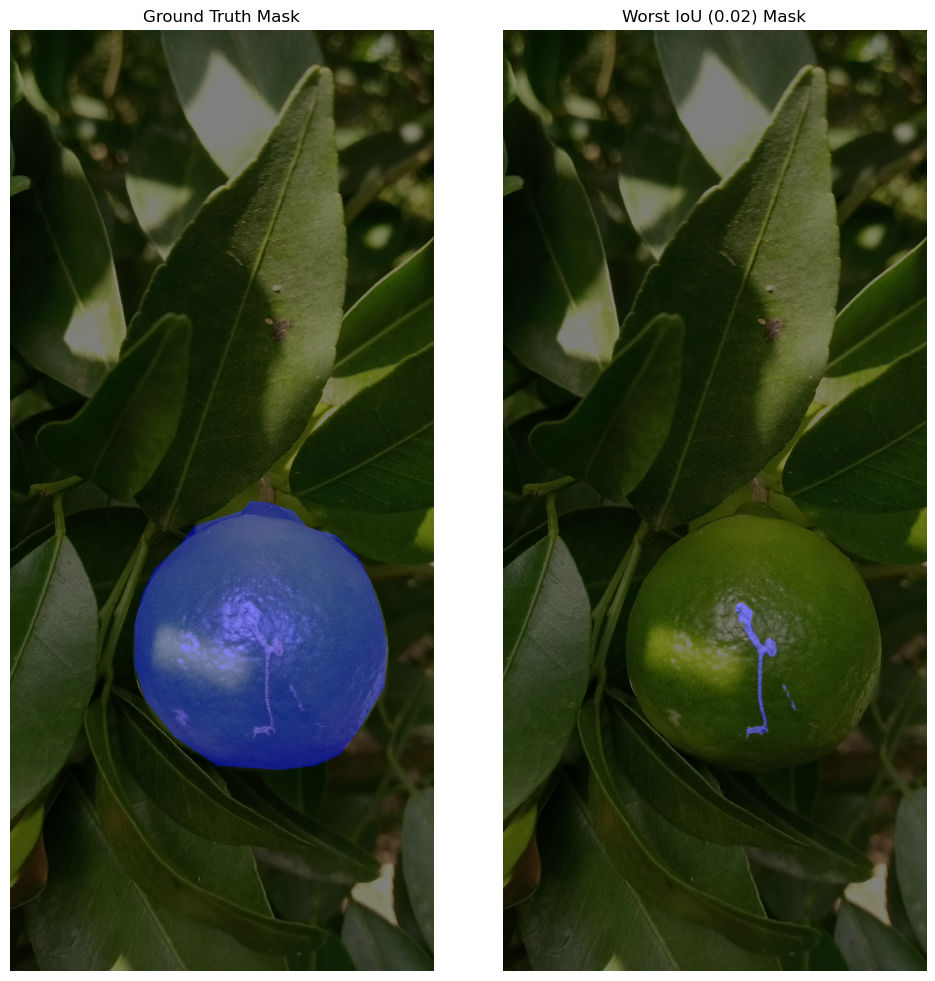

In [20]:
def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
    """
    Overlay a mask on an image.
    """
    # print(mask.shape, image.shape)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 255] = color
    return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

zero_shot_points = zeroshot_sam(model, SAMDataSet(kind=0, data_labels=data_labels,processor=processor, for_loader=False), device, use_points=True)
ious, best_iou, worst_iou, best_iou_img, worst_iou_img, times = zero_shot_points

fig= plt.figure(figsize=(10,8))
plt.hist(ious.values())
plt.title('Histogram of Zero Shot Points IoU of SAM Avg. IoU: {:.2f}'.format(mean(ious.values())))
plt.xlabel('IoU')
plt.ylabel('Frequency')
fig.savefig('zero_shot_iou_points.pdf')
plt.show()

subplot_images([overlay_mask(best_iou_img[0], best_iou_img[1]*255),
overlay_mask(best_iou_img[0], best_iou_img[2]*255)], titles=['Ground Truth Mask', f'Best IoU ({best_iou:.2f}) Mask'], fig_size=(10,10)).savefig('zero_shot_best_points.pdf')
subplot_images([overlay_mask(worst_iou_img[0], worst_iou_img[1]*255),
overlay_mask(worst_iou_img[0], worst_iou_img[2]*255)], titles=['Ground Truth Mask', f'Worst IoU ({worst_iou:.2f}) Mask'], fig_size=(10,10)).savefig('zero_shot_worst_points.pdf')



100%|██████████| 300/300 [03:39<00:00,  1.36it/s]


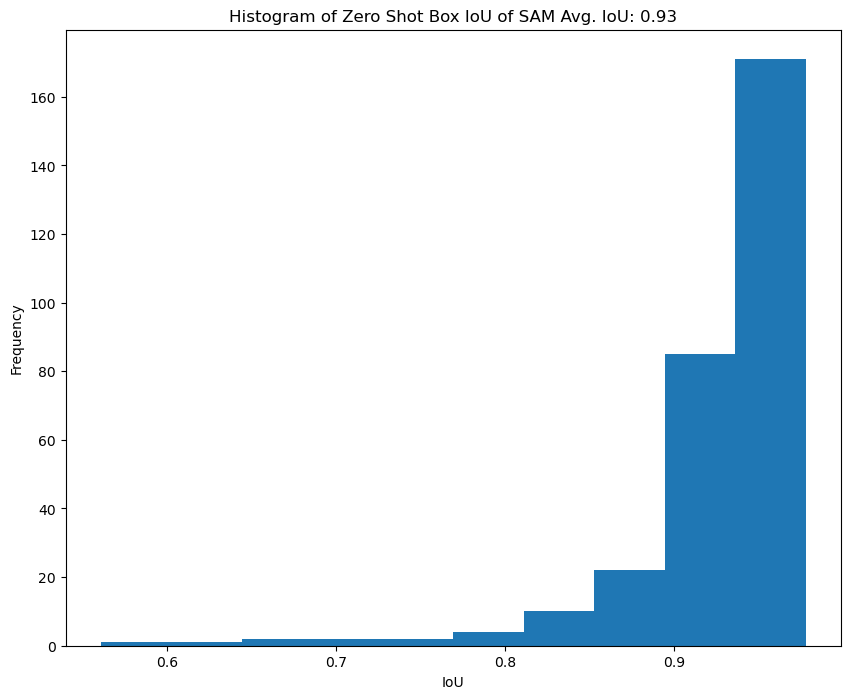

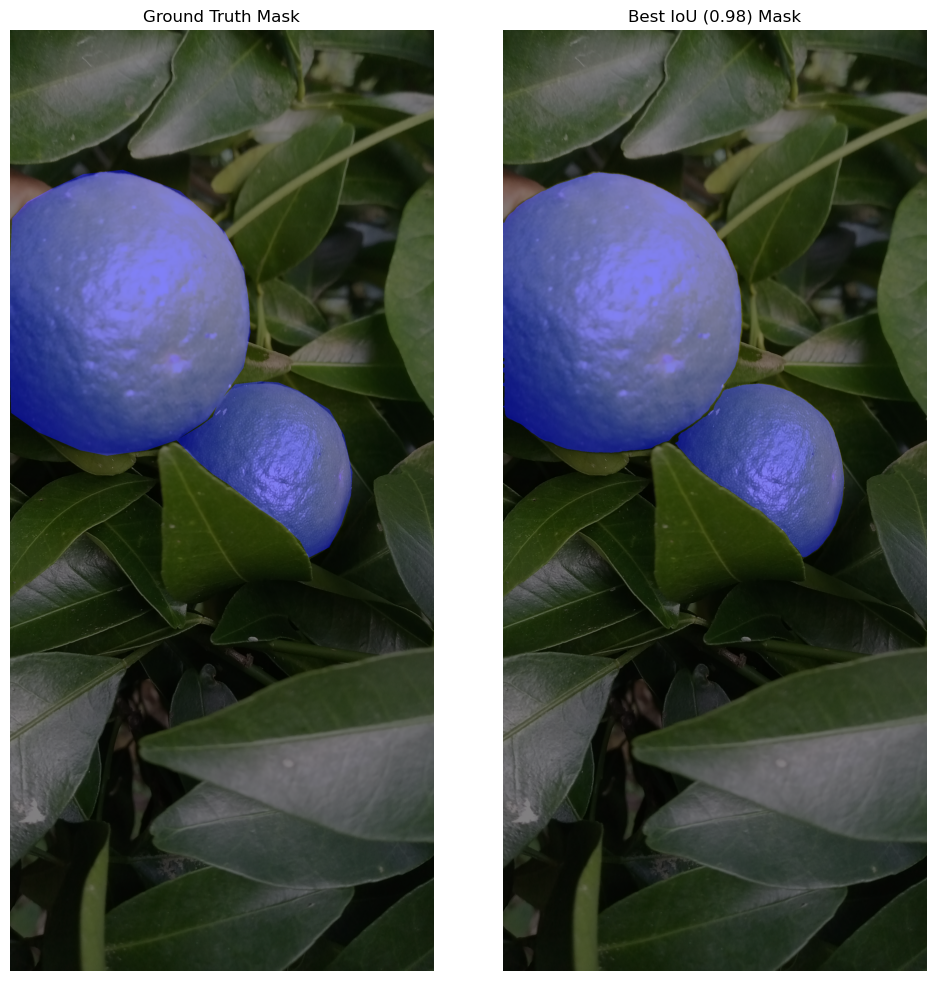

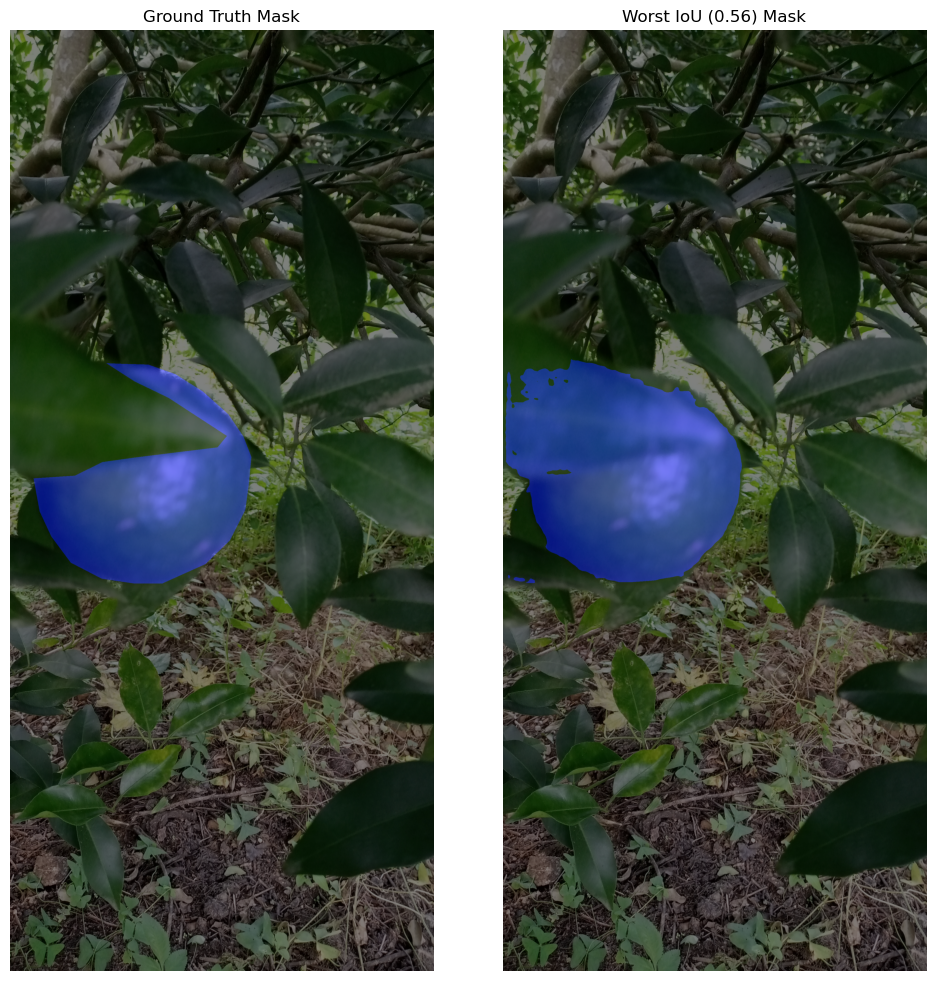

In [21]:
zero_shot_boxes = zeroshot_sam(model, SAMDataSet(kind=0, data_labels=data_labels,processor=processor, for_loader=False), device, use_points=False)
ious, best_iou, worst_iou, best_iou_img, worst_iou_img,times = zero_shot_boxes

fig= plt.figure(figsize=(10,8))
plt.hist(ious.values())
plt.title('Histogram of Zero Shot Box IoU of SAM Avg. IoU: {:.2f}'.format(mean(ious.values())))
plt.xlabel('IoU')
plt.ylabel('Frequency')
fig.savefig('zero_shot_iou_box.pdf')
plt.show()

subplot_images([overlay_mask(best_iou_img[0], best_iou_img[1]*255),
overlay_mask(best_iou_img[0], best_iou_img[2]*255)], titles=['Ground Truth Mask', f'Best IoU ({best_iou:.2f}) Mask'], fig_size=(10,10)).savefig('zero_shot_best_box.pdf')
subplot_images([overlay_mask(worst_iou_img[0], worst_iou_img[1]*255),
overlay_mask(worst_iou_img[0], worst_iou_img[2]*255)], titles=['Ground Truth Mask', f'Worst IoU ({worst_iou:.2f}) Mask'], fig_size=(10,10)).savefig('zero_shot_worst_box.pdf')


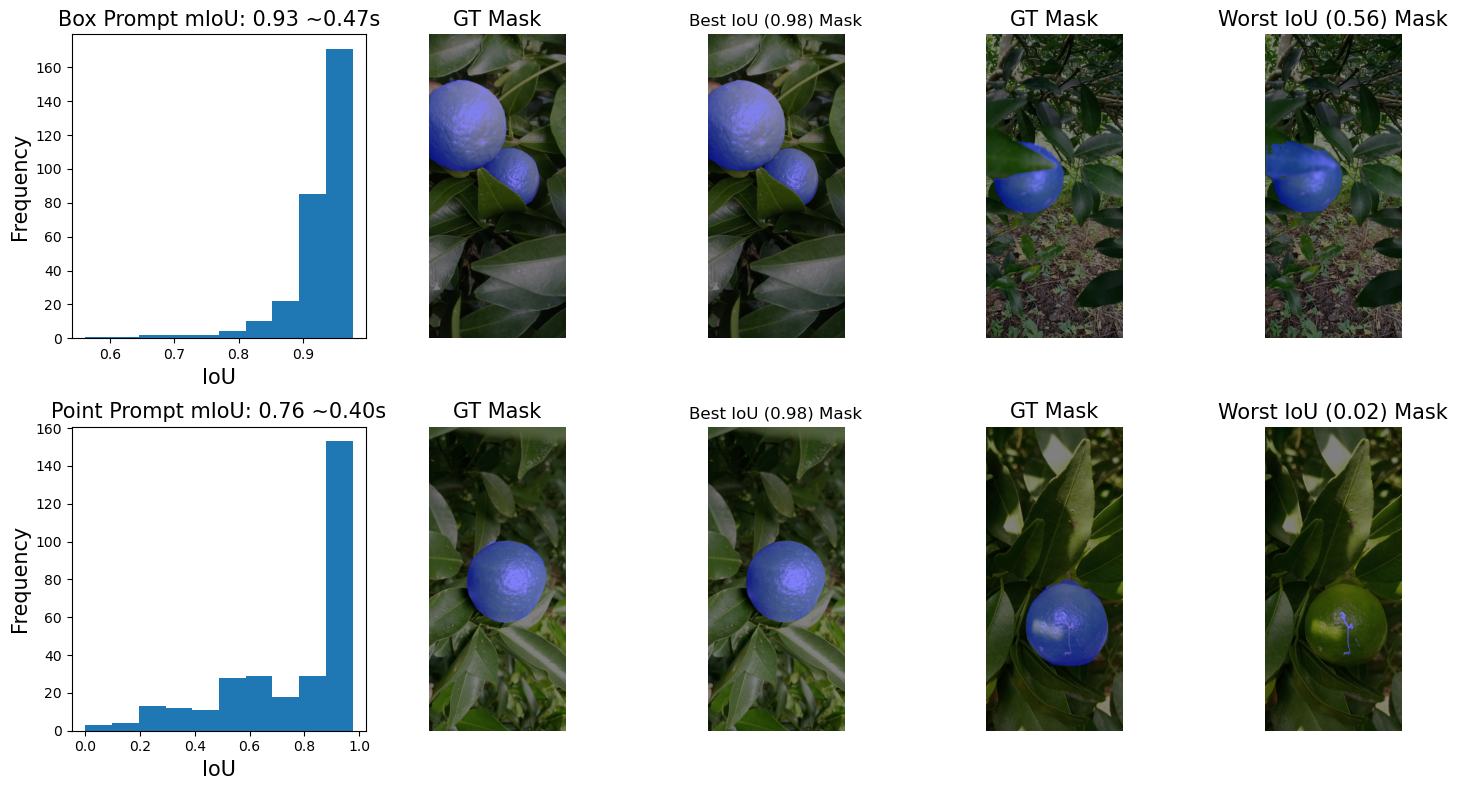

In [27]:
zero_shot = [zero_shot_boxes, zero_shot_points]
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
legends = ['Box Prompt', 'Point Prompt']

for i, (zero_shot_type, ax) in enumerate(zip(zero_shot, axes)):
    ious, best_iou, worst_iou, best_iou_img, worst_iou_img, times = zero_shot_type
    
    # Plot histogram
    ax[0].hist(ious.values())
    ax[0].set_title('{} mIoU: {:.2f} ~{:.2f}s'.format(legends[i], mean(ious.values()), mean(times)), fontsize=15)
    ax[0].set_xlabel('IoU', fontsize=15)
    ax[0].set_ylabel('Frequency', fontsize=15)
    
    # Display images
    ax[1].imshow(overlay_mask(best_iou_img[0], best_iou_img[1]*255))
    ax[1].set_title('GT Mask', fontsize=15)
    ax[2].imshow(overlay_mask(best_iou_img[0], best_iou_img[2]*255))
    ax[2].set_title(f'Best IoU ({best_iou:.2f}) Mask', fontsize=12)
    ax[3].imshow(overlay_mask(worst_iou_img[0], worst_iou_img[1]*255))
    ax[3].set_title('GT Mask', fontsize=15)
    ax[4].imshow(overlay_mask(worst_iou_img[0], worst_iou_img[2]*255))
    ax[4].set_title(f'Worst IoU ({worst_iou:.2f}) Mask', fontsize=15)

    # Hide axis ticks for image plots
    for j in range(1, 5):
        ax[j].axis('off')

plt.tight_layout()
fig.savefig('zero_shot_sam.pdf')
plt.show()

In [23]:

# from tqdm import tqdm
# from statistics import mean
# import torch

# from torch.optim import Adam
# import monai


# def iou_score(predicted_mask, ground_truth_mask):
#     intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
#     union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
#     iou = (intersection + 1e-6) / (union + 1e-6)
#     return iou.mean().item()

# # Note: Hyperparameter tuning could improve performance here
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# num_epochs = 100

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.eval()
# ious={}

# best_iou = 0
# worst_iou=1
# best_iou_img = None
# worst_iou_img=None

# for inputs in tqdm(SAMDataSet(kind=0, data_labels=data_labels,processor=processor, for_loader=False)):
#     points = []
#     for box in inputs["input_boxes"]:
#         xc=(box[0]+box[2])//2
#         yc=(box[1]+box[3])//2
#         points.append([xc,yc])
#     points = torch.tensor([points])
#     outputs = model(pixel_values=inputs["pixel_values"].unsqueeze(0).to(device),
#                     input_boxes=inputs["input_boxes"].unsqueeze(0).to(device),
#                     # input_points = points.unsqueeze(0).to(device),
#                     multimask_output=False)
#     # compute loss
#     predicted_masks = outputs.pred_masks.squeeze(1)
#     ground_truth_masks = inputs["ground_truth_mask"]==255
#     masks=processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
#                                                         inputs["original_sizes"].cpu().unsqueeze(0), 
#                                                         inputs["reshaped_input_sizes"].cpu().unsqueeze(0))
#     pred_mask = (masks[0].sum(axis=0)==1).squeeze(0)
#     iou1 = iou_score(pred_mask, torch.from_numpy(ground_truth_masks))
#     if iou1>best_iou:
#         best_iou = iou1
#         best_iou_img = [inputs['orig_img'], ground_truth_masks, pred_mask.numpy()]
#     if iou1<worst_iou:
#         worst_iou = iou1
#         worst_iou_img = [inputs['orig_img'], ground_truth_masks, pred_mask.numpy()]
#     ious[inputs['img_name']]=iou1

In [24]:
# points.shape, inputs["input_boxes"].unsqueeze(0).shape

In [25]:
# def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
#     """
#     Overlay a mask on an image.
#     """
#     # print(mask.shape, image.shape)
#     colored_mask = np.zeros_like(image)
#     colored_mask[mask == 255] = color
#     return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

# subplot_images([overlay_mask(best_iou_img[0], best_iou_img[1]*255),
# overlay_mask(best_iou_img[0], best_iou_img[2]*255)], titles=['Ground Truth Mask', f'Best IoU Mask IoU {best_iou:.2f}'], fig_size=(10,10)).savefig('zero_shot_best_points_boxes.pdf')
# subplot_images([overlay_mask(worst_iou_img[0], worst_iou_img[1]*255),
# overlay_mask(worst_iou_img[0], worst_iou_img[2]*255)], titles=['Ground Truth Mask', f'Worst IoU Mask IoU {worst_iou:.2f}'], fig_size=(10,10)).savefig('zero_shot_worst_points_boxes.pdf')


In [5]:
!pwd

/home/hpc/rlvl/rlvl102h


## Training From SAM Repo

In [5]:
import sys
sys.path.append('/home/hpc/rlvl/rlvl102h/segment-anything')

from segment_anything import SamPredictor, sam_model_registry
model_type = 'vit_b'
# checkpoint = '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/sam_vit_b_01ec64.pth'
checkpoint = '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_sam_2024-08-03/best_model.pth'
device = 'cuda:0'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train()

/home/hpc/rlvl/rlvl102h/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Datasets

In [6]:
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image

class DataLabels:
    def __init__(self, root_dir, labels_file, shuffle_seed=42, split_ratio=0.8, max_samples=-1):
        """
        root_dir: From where all dataset is being read.
        labels_file: Labels file path.
        shuffle_seed: to handle random split.
        split_ratio: first half train, second will be test
        max_samples: max number of samples to take. -1 means all.
        """
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.images_dir = root_dir
        self.shuffle_seed = shuffle_seed
        self.split_ratio = split_ratio
        self.max_samples = max_samples

        
        self.labels, self.label_counts = self.load_labels(labels_file)
        np.random.seed(shuffle_seed)
        fnames = list(self.labels.keys())
        np.random.shuffle(fnames)
        self.idxs = list(range(len(fnames)))
        self.labels = {k: self.labels[k] for k in fnames}
        self.train_idx = self.idxs[:int(len(self.labels) * split_ratio)]
        self.valid_idx = self.idxs[len(self.train_idx):]
        self.train_labels = {fnames[k]: self.labels[fnames[k]] for k in self.train_idx}
        self.valid_labels = {fnames[k]: self.labels[fnames[k]] for k in self.valid_idx}

    def load_labels(self, labels_dir):
        # Load segmentation labels from JSON file
        with open(labels_dir, 'r') as f:
            segmentation_data = json.load(f)

        final_labels = {}
        label_counts = {}
        self.label_names = []
        img_cnts = 0

        for sm in segmentation_data:
            img_name = "IMG" + sm['image'].split('-IMG')[1]
            img_dict = {}

            if sm.get('label') is None:
                continue

            for labels in sm['label']:
                width = labels['original_width']
                height = labels['original_height']
                points = np.array(labels['points']).reshape(-1, 2)
                points[:, 0] = points[:, 0] * width / 100
                points[:, 1] = points[:, 1] * height / 100

                label_names = labels['polygonlabels']

                for label_name in label_names:
                    self.label_names.append(label_name)
                    if img_dict.get(label_name) is None:
                        img_dict[label_name] = []
                    img_dict[label_name].append(points)

            final_labels[img_name] = img_dict
            label_counts[img_name] = {k: len(v) for k, v in img_dict.items()}
            img_cnts += 1
            
            if img_cnts >= self.max_samples and self.max_samples > 0:
                break

        self.label_names = sorted(list(set(self.label_names)))
        return final_labels, label_counts

class SAMDataSet(Dataset):
    def __init__(self, kind=1, data_labels=None,
                 color_space="RGB"):
        """
        kind: 1 for training and 0 for validation.
        data_labels: dictionary containing labels.
        transform: what transformation to apply.
        color_space: rgb/hsv or any other.
        multiclass: if True, target will be N,H,W else, N,C,H,W
        """
        self.data_labels = data_labels
        self.color_space=color_space
        # 1 for train, 0 for valid
        if kind == 1:
            self.curr_labels = self.data_labels.train_labels
        else:
            self.curr_labels = self.data_labels.valid_labels

    def __len__(self):
        return len(self.curr_labels)

    def __getitem__(self, idx):
        img_name = list(self.curr_labels.keys())[idx]
        img_path = os.path.join(self.data_labels.images_dir, img_name)

        # Load image
        image = Image.open(img_path).convert(self.color_space)
        
        # image = image.resize((self.width, self.height))
        img_arr = np.array(image)
        
        
        
        # Create masks for each class label
        background = np.zeros(img_arr.shape[:2], dtype=np.uint8) + 255
        healthy = np.zeros(img_arr.shape[:2], dtype=np.uint8)
        infected = np.zeros(img_arr.shape[:2], dtype=np.uint8)

        masks_dict = {"Background": background, "Healthy": healthy, "Infected": infected}
        bb_dict={k:[] for k in masks_dict.keys()}

        bboxes = []
        individual_masks = []
        for label_name, points_list in self.curr_labels[img_name].items():
            mask = masks_dict.get(label_name)
            # Draw each mask on the blank mask
            for points in points_list:
                mask = np.zeros_like(mask)
                points = np.round(points).astype(int)
                mask = cv2.fillPoly(mask, [points], 255)
                bounding_rect = cv2.boundingRect(points)
                background = cv2.fillPoly(background, [points], 0)
                bb_dict[label_name].append(bounding_rect)
                x, y, w, h= bounding_rect
                bboxes.append([x, y, x+w, y+h])
                individual_masks.append(mask)

            masks_dict[label_name] = mask
        background = background

        masks = np.zeros((img_arr.shape[0], img_arr.shape[1], 3), dtype=np.uint8)
        masks[:, :, 0] = masks_dict["Background"]
        masks[:, :, 1] = masks_dict["Healthy"]
        masks[:, :, 2] = masks_dict["Infected"]

        
        inputs = {'input_boxes':np.array(bboxes)}
        inputs['ground_truth_mask'] = 255-masks_dict['Background']
        inputs['img_name']=img_name
        inputs['orig_img'] = img_arr
        inputs['ground_truth_masks'] = np.array(individual_masks)

        

        # print(idx)
        return inputs

data_labels = DataLabels(root_dir=CONFIGS['data_dir'], 
                         labels_file=CONFIGS['labels_dir'], 
                         split_ratio=CONFIGS['train_size'],
                        max_samples=CONFIGS['max_data_samples'],
                        shuffle_seed=CONFIGS['shuffle_seed'])

train_dataset = SAMDataSet(kind=1, data_labels=data_labels)
test_dataset = SAMDataSet(kind=0, data_labels=data_labels)

In [7]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

def transform_inputs(inputs, model):
  transformed_data = defaultdict(dict)
  image = inputs['orig_img']
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])


  transformed_data['image'] = input_image
  transformed_data['input_size'] = input_size

  transformed_data['original_image_size'] = original_image_size
  return transformed_data, transform
transform_inputs(test_dataset[0], sam_model)  

(defaultdict(dict,
             {'image': tensor([[[[ 1.6495,  1.1358, -0.1314,  ...,  0.0000,  0.0000,  0.0000],
                        [ 1.4269,  0.3652, -0.7822,  ...,  0.0000,  0.0000,  0.0000],
                        [ 0.9132, -0.3369, -1.1760,  ...,  0.0000,  0.0000,  0.0000],
                        ...,
                        [-0.6965, -0.7479, -0.7822,  ...,  0.0000,  0.0000,  0.0000],
                        [-0.7479, -0.7993, -0.8507,  ...,  0.0000,  0.0000,  0.0000],
                        [-0.7650, -0.7993, -0.8678,  ...,  0.0000,  0.0000,  0.0000]],
              
                       [[ 2.4286,  2.1310,  1.0980,  ...,  0.0000,  0.0000,  0.0000],
                        [ 2.3235,  1.6583,  0.6954,  ...,  0.0000,  0.0000,  0.0000],
                        [ 2.0609,  1.2031,  0.2927,  ...,  0.0000,  0.0000,  0.0000],
                        ...,
                        [ 0.1877,  0.1176,  0.0826,  ...,  0.0000,  0.0000,  0.0000],
                        [ 0.1352,  0.0

In [17]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

def iou_score(predicted_mask, ground_truth_mask):
    intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum(axis=0)
    union = torch.logical_or(predicted_mask, ground_truth_mask).sum(axis=0)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def dice_loss(predicted_mask, ground_truth_mask):
    """
    Calculate Dice loss between two boolean masks of shape (H, W).
    
    Args:
    predicted_mask (torch.Tensor): Predicted mask tensor of shape (H, W).
    ground_truth_mask (torch.Tensor): Ground truth mask tensor of shape (H, W).
    
    Returns:
    float: Dice loss value.
    """
    # Convert boolean masks to float tensors
    predicted_mask = predicted_mask.float()
    ground_truth_mask = ground_truth_mask.float()
    
    # Calculate intersection and union
    intersection = (predicted_mask * ground_truth_mask).sum(axis=0)
    union = predicted_mask.sum(axis=0) + ground_truth_mask.sum(axis=0)
    
    # Calculate Dice coefficient
    dice_coefficient = (2 * intersection + 1e-6) / (union + 1e-6)
    
    # Calculate Dice loss
    dice_loss_value = 1 - dice_coefficient
    
    return dice_loss_value.mean()


# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = dice_loss
# loss_fn = torch.nn.BCELoss()
# keys = list(bbox_coords.keys())

In [18]:
def sam_step(inputs, sam_model, loss_fn, use_points=False, use_box=True):
  bbox_coords = inputs['input_boxes']
  transformed_data, transform = transform_inputs(inputs, sam_model)

  input_image = transformed_data['image'].to(device)
  input_size = transformed_data['input_size']
  original_image_size = transformed_data['original_image_size']
  ground_truth_masks=inputs['ground_truth_masks']

  # No grad here as we don't want to optimise the encoders
  with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)

    prompt_box = np.array(bbox_coords)
    box = transform.apply_boxes(prompt_box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    points=None
    if use_points:
      points = []
      labels = []
      for box in bbox_coords:
        xc=(box[0]+box[2])//2
        yc=(box[1]+box[3])//2
        points.append([xc,yc])
        labels.append(1)
      labels = torch.tensor([labels]).to(device)
      points = torch.tensor([points]).to(device)
      points = (points,labels)
    if not use_box:
      box_torch = None
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=points,
        boxes=box_torch,
        masks=None,
    )
  low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )

  upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
  binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
  # binary_mask = threshold(upscaled_masks, 0.5, 0)

  gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks, (len(binary_mask), 1, 
                                                                    ground_truth_masks.shape[1], 
                                                                    ground_truth_masks.shape[2]))).to(device)
  gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
  loss = loss_fn(binary_mask, gt_binary_mask)
  iou = iou_score(binary_mask, gt_binary_mask)
  
  return loss, binary_mask, gt_binary_mask, iou


for epoch in range(num_epochs):
  epoch_losses = []
  epoch_ious=[]
  # Just train on the first 20 examples
  for i in range(20):
    inputs = train_dataset[i]
    loss, binary_mask, gt_binary_mask, iou = sam_step(inputs, sam_model, loss_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_ious.append(iou)
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}, Mean IoU: {mean(epoch_ious)}')

  break

EPOCH: 0
Mean loss: 0.01141698689898476, Mean IoU: 0.9885449588298798


### Check Zeroshot IoUs

In [16]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

sam_checkpoint = "/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)




In [72]:
t = test_dataset[0]
oimg = t['orig_img']
input_bbox = t['input_boxes']
input_bbox


array([[ 603, 1323, 1718, 2494],
       [1482, 1718, 1872, 2689]])

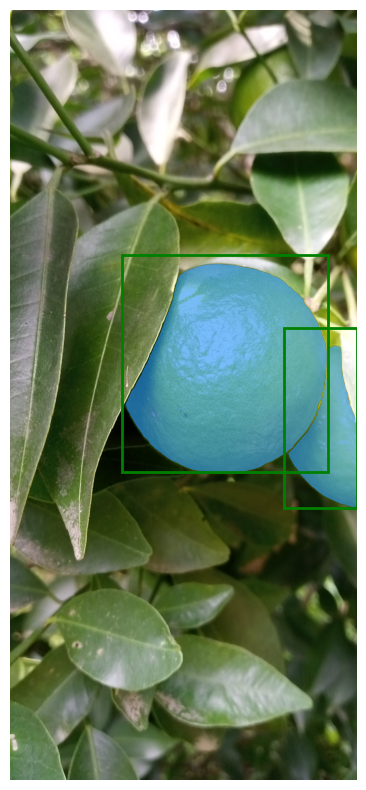

In [73]:
predictor.set_image(oimg)
# masks_orig, _, _ = predictor.predict(
#     point_coords=None,
#     box=np.array(input_bbox[0]),
#     multimask_output=False,
# )
transformed_boxes = predictor.transform.apply_boxes_torch(torch.tensor(input_bbox, device=predictor.device), 
oimg.shape[:2])
masks_orig, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(oimg)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
for box in input_bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()


tensor([False, False,  True])

In [50]:
# plt.imshow(masks_orig.squeeze(1).detach().cpu().numpy().sum(axis=0))
pred_mask = masks_orig.squeeze(1).detach().cpu().sum(axis=0)
gtm=(t['ground_truth_mask']>0)
pdm= (pred_mask>0)
iou = iou_score(masks_orig.squeeze(1).detach().cpu().sum(axis=0)>0, 
torch.from_numpy(t['ground_truth_mask']>0))
loss = dice_loss(masks_orig.squeeze(1).detach().cpu().sum(axis=0)>0, 
torch.from_numpy(t['ground_truth_mask']>0))
iou, loss

(0.9279553890228271, tensor(0.0448))

#### Using Predictor

In [68]:

epoch_ious=[]
epoch_losses=[]
best_results = []
worst_results = []
best_iou=0
worst_iou=1
loss_fn = dice_loss
# Just train on the first 20 examples
pbar = tqdm(total=len(test_dataset))
with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs = test_dataset[i]
        predictor.set_image(inputs['orig_img'])
        transformed_boxes = predictor.transform.apply_boxes_torch(
            torch.tensor(inputs['input_boxes'], device=predictor.device), 
        inputs['orig_img'].shape[:2])
        masks_orig, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        binary_mask = masks_orig.squeeze(1).detach().cpu().sum(axis=0)>0
        gt_binary_mask = torch.from_numpy(inputs['ground_truth_mask']>0)
        iou = iou_score(binary_mask,
                        gt_binary_mask)
        epoch_ious.append(iou)
        if iou>best_iou:
            best_iou=iou
            best_results=[inputs['orig_img'], 
            inputs['ground_truth_mask'], 
            255*(binary_mask.numpy().astype(np.uint8))]
        if iou<worst_iou:
            worst_iou=iou
            worst_results=[inputs['orig_img'], inputs['ground_truth_mask'], 
            255*(binary_mask.numpy().astype(np.uint8))]
        # break
        pbar.update(1)
        pbar.set_postfix({'mIoU': mean(epoch_ious), 'best_iou': best_iou, 'worst_iou': worst_iou})
print(f'Mean IoU: {mean(epoch_ious):0.2f}')

100%|██████████| 300/300 [02:52<00:00,  1.71it/s, mIoU=0.925, best_iou=0.985, worst_iou=0.724]

Mean IoU: 0.92


300

#### Using sam_step

In [25]:
epoch_ious=[]
epoch_losses=[]
best_results = []
worst_results = []
best_iou=0
worst_iou=1
loss_fn = dice_loss
# Just train on the first 20 examples

with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs = test_dataset[i]
        loss, binary_mask, gt_binary_mask, iou = sam_step(inputs, sam_model, loss_fn, use_points=True, use_box=False)
        binary_mask = binary_mask.sum(axis=0).squeeze(0).cpu().numpy().astype(np.uint8)*255
        gt_binary_mask = gt_binary_mask.sum(axis=0).squeeze(0).cpu().numpy().astype(np.uint8)*255
        
        epoch_ious.append(iou)
        epoch_losses.append(loss.item())
        if iou>best_iou:
            best_iou=iou
            best_results=[inputs['orig_img'], gt_binary_mask, binary_mask]
        if iou<worst_iou:
            worst_iou=iou
            worst_results=[inputs['orig_img'], gt_binary_mask, binary_mask]
        # break
print(f'Mean IoU: {mean(epoch_ious)}, Mean Loss: {mean(epoch_losses)}')

Mean IoU: 0.5881660006816188, Mean Loss: 0.3679898530865709


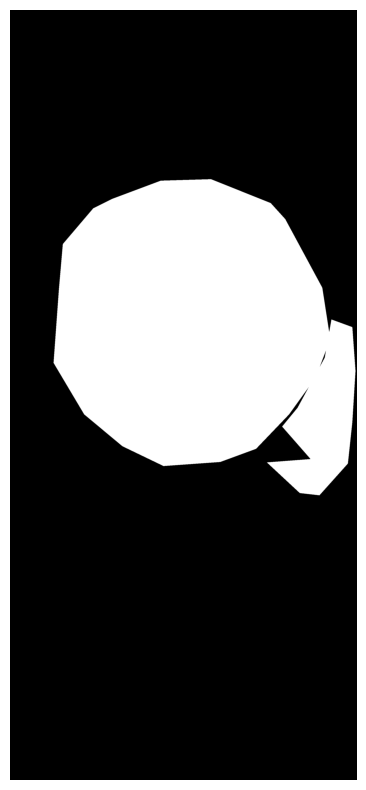

#### Overlay Results

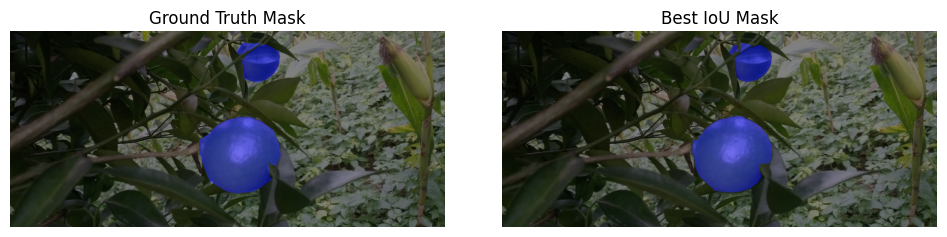

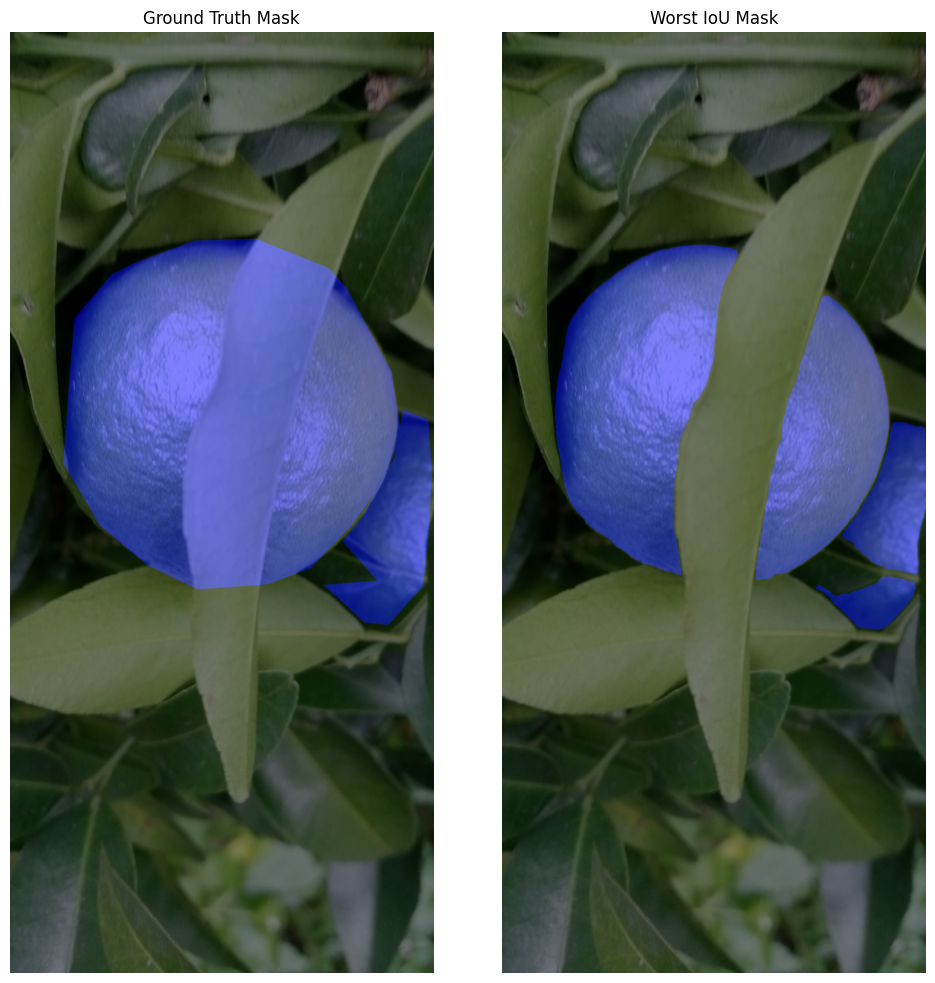

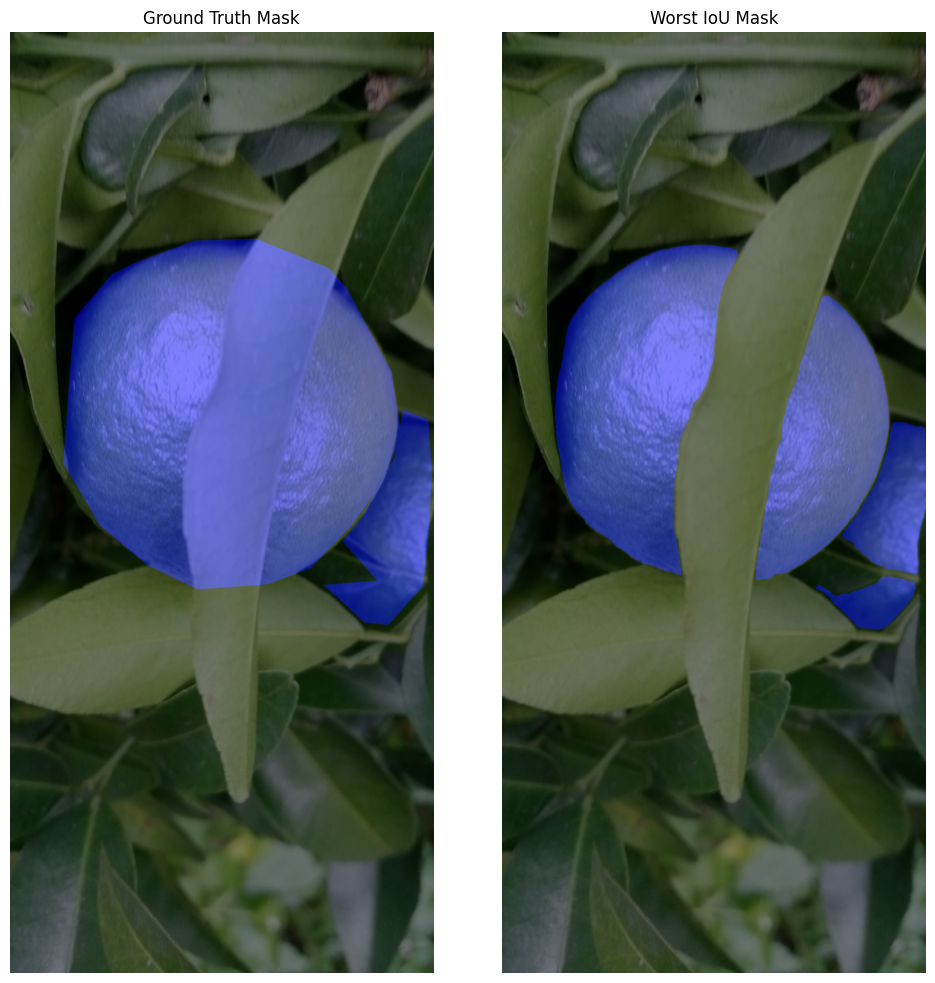

In [69]:
def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
    """
    Overlay a mask on an image.
    """
    # print(mask.shape, image.shape)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 255] = color
    return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

subplot_images([overlay_mask(best_results[0], best_results[1]),
overlay_mask(best_results[0], best_results[2])], titles=['Ground Truth Mask', 'Best IoU Mask'], fig_size=(10,10))#.savefig('zero_shot_best_bboxes.pdf')
subplot_images([overlay_mask(worst_results[0], worst_results[1]),
overlay_mask(worst_results[0], worst_results[2])], titles=['Ground Truth Mask', 'Worst IoU Mask'], fig_size=(10,10))#.savefig('zero_shot_worst_bboxes.pdf')


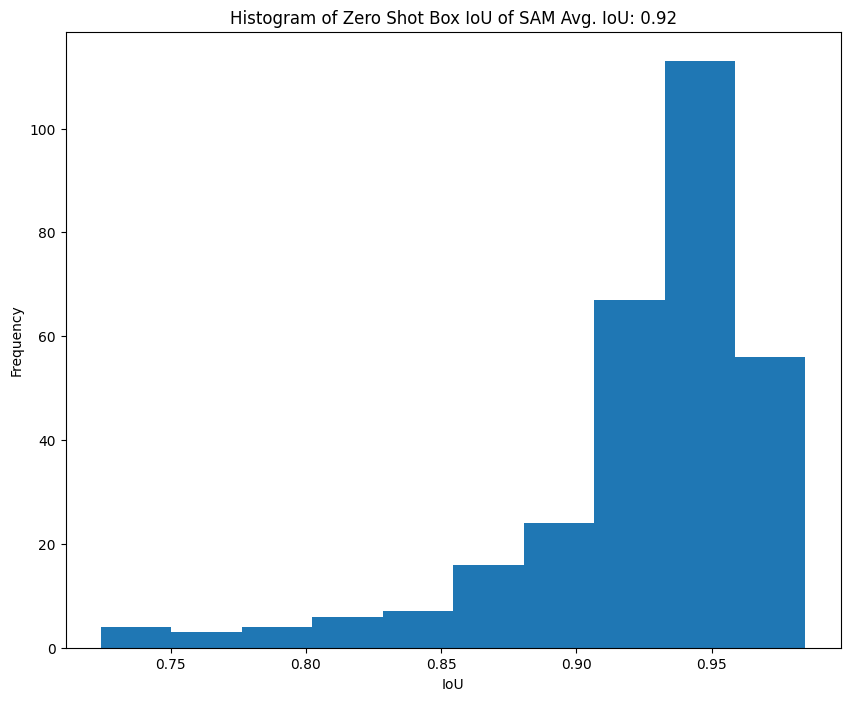

In [71]:
fig = plt.figure(figsize=(10,8))
plt.hist(epoch_ious)
plt.title('Histogram of Zero Shot Box IoU of SAM Avg. IoU: {:.2f}'.format(mean(epoch_ious)))
plt.xlabel('IoU')
plt.ylabel('Frequency')
fig.savefig('zero_shot_sam_box.pdf')
plt.show()

### Finetuned

#### Curves

In [9]:
import pickle as pkl

with open('/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_sam_2024-09-08/logs.pkl', 'rb') as f:
    logs = pkl.load(f)

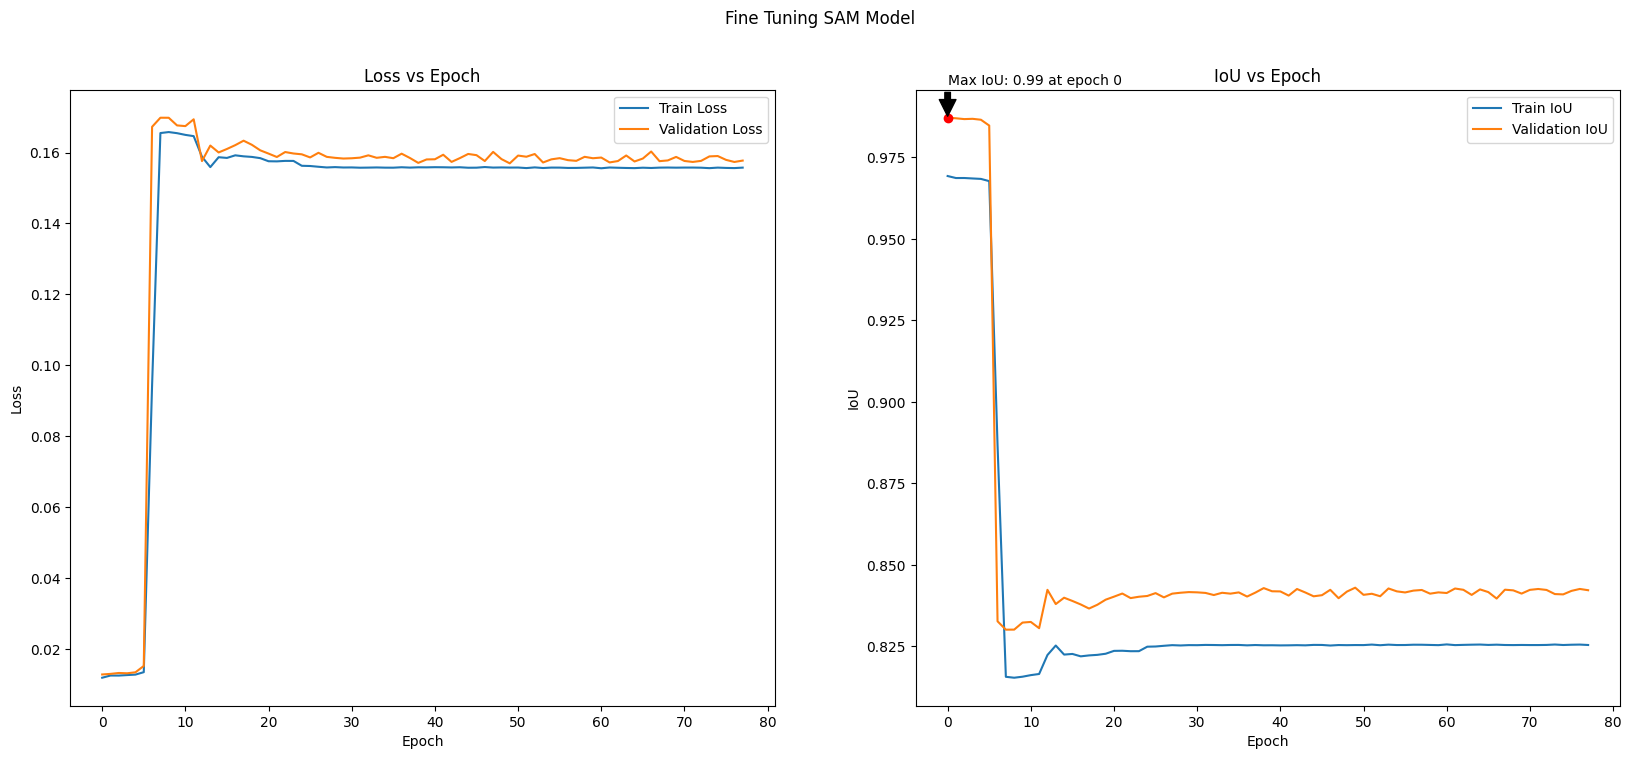

In [10]:
max_val_iou = max(logs['val_iou'])
max_val_iou_epoch = logs['val_iou'].index(max_val_iou)

fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
axes[0].plot(logs['train_loss'], label='Train Loss')
axes[0].plot(logs['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epoch')
axes[0].legend()

axes[1].plot(logs['train_iou'], label='Train IoU')
axes[1].plot(logs['val_iou'], label='Validation IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU vs Epoch')
axes[1].legend()
axes[1].plot(max_val_iou_epoch, max_val_iou, 'ro')  # 'ro' for red circle marker
axes[1].annotate(f'Max IoU: {max_val_iou:.2f} at epoch {max_val_iou_epoch}', 
                 xy=(max_val_iou_epoch, max_val_iou), 
                 xytext=(max_val_iou_epoch, max_val_iou + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))
fig.suptitle("Fine Tuning SAM Model")
fig.savefig('sam_fine_tune.pdf')
plt.show()

#### Performance with Sam Step

In [14]:
from copy import deepcopy
import sys
sys.path.append('/home/hpc/rlvl/rlvl102h/segment-anything')

from segment_anything import SamPredictor, sam_model_registry
model_type = 'vit_b'
checkpoint = '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/sam_weights/sam_vit_b_01ec64.pth'
# checkpoint = '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_sam_2024-08-03/best_model.pth'
device = 'cuda:0'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train()
tuned_path = '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_sam_2024-09-08/best_model.pth'

finetuned_sam = deepcopy(sam_model)
finetuned_sam.load_state_dict(torch.load(tuned_path))


/home/hpc/rlvl/rlvl102h/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/tmp/ipykernel_1104767/4

<All keys matched successfully>

In [19]:
from tqdm import tqdm

finetuned_epoch_ious=[]
finetuned_epoch_losses=[]
finetuned_best_results = []
finetuned_worst_results = []
finetuned_best_iou=0
finetuned_worst_iou=1
loss_fn = dice_loss
# Just train on the first 20 examples

pbar = tqdm(total=len(test_dataset))
with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs = test_dataset[i]
        loss, binary_mask, gt_binary_mask, iou = sam_step(inputs, finetuned_sam, loss_fn)
        binary_mask = binary_mask.sum(axis=0).squeeze(0).cpu().numpy().astype(np.uint8)*255
        gt_binary_mask = gt_binary_mask.sum(axis=0).squeeze(0).cpu().numpy().astype(np.uint8)*255
        
        finetuned_epoch_ious.append(iou)
        finetuned_epoch_losses.append(loss.item())
        if iou>finetuned_best_iou:
            finetuned_best_iou=iou
            finetuned_best_results=[inputs['orig_img'], gt_binary_mask, binary_mask]
        if iou<finetuned_worst_iou:
            finetuned_worst_iou=iou
            finetuned_worst_results=[inputs['orig_img'], gt_binary_mask, binary_mask]
        # break
        pbar.update(1)
        pbar.set_postfix({'mIoU': mean(finetuned_epoch_ious), 'best_iou': finetuned_best_iou, 'worst_iou': finetuned_worst_iou})
print(f'Mean IoU: {mean(finetuned_epoch_ious)}, Mean Loss: {mean(finetuned_epoch_losses)}')

100%|██████████| 300/300 [02:29<00:00,  1.96it/s, mIoU=0.987, best_iou=0.998, worst_iou=0.868]

Mean IoU: 0.9871095877885818, Mean Loss: 0.01287361437571235


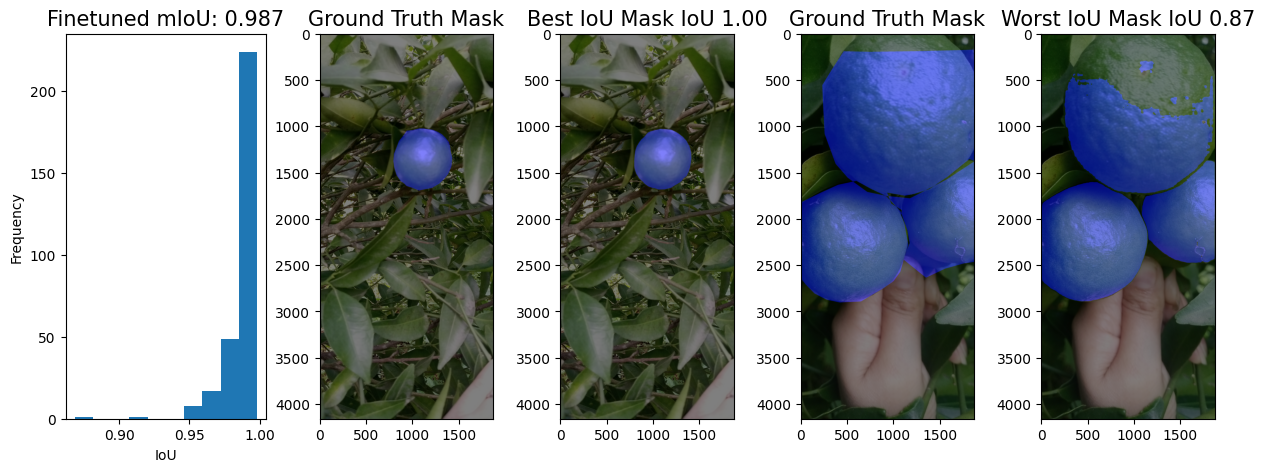

In [20]:
def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
    """
    Overlay a mask on an image.
    """
    # print(mask.shape, image.shape)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 255] = color
    return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
axes[0].set_title('Finetuned mIoU: {:.3f}'.format(mean(finetuned_epoch_ious)),
                   fontsize=15)
axes[0].set_xlabel('IoU')
axes[0].set_ylabel('Frequency')
axes[0].hist(finetuned_epoch_ious)
axes[1].imshow(overlay_mask(finetuned_best_results[0], finetuned_best_results[1]))
axes[1].set_title('Ground Truth Mask', fontsize=15)
axes[2].imshow(overlay_mask(finetuned_best_results[0], finetuned_best_results[2]))
axes[2].set_title(f'Best IoU Mask IoU {finetuned_best_iou:.2f}', fontsize=15)
axes[3].imshow(overlay_mask(finetuned_worst_results[0], 
                            finetuned_worst_results[1]))
axes[3].set_title('Ground Truth Mask', fontsize=15)
axes[4].imshow(overlay_mask(finetuned_worst_results[0], 
                            finetuned_worst_results[2]))
axes[4].set_title(f'Worst IoU Mask IoU {finetuned_worst_iou:.2f}', fontsize=15)
fig.savefig('finetuned_sam_results.pdf')
plt.show()


#### Performance with predictor

In [12]:
predictor = SamPredictor(finetuned_sam)
epoch_ious=[]
epoch_losses=[]
best_results = []
worst_results = []
best_iou=0
worst_iou=1
loss_fn = dice_loss
# Just train on the first 20 examples
pbar = tqdm(total=len(test_dataset))
with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs = test_dataset[i]
        predictor.set_image(inputs['orig_img'])
        transformed_boxes = predictor.transform.apply_boxes_torch(
            torch.tensor(inputs['input_boxes'], device=predictor.device), 
        inputs['orig_img'].shape[:2])
        masks_orig, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        binary_mask = masks_orig.squeeze(1).detach().cpu().sum(axis=0)>0
        gt_binary_mask = torch.from_numpy(inputs['ground_truth_mask']>0)
        iou = iou_score(binary_mask,
                        gt_binary_mask)
        epoch_ious.append(iou)
        if iou>best_iou:
            best_iou=iou
            best_results=[inputs['orig_img'], 
            inputs['ground_truth_mask'], 
            255*(binary_mask.numpy().astype(np.uint8))]
        if iou<worst_iou:
            worst_iou=iou
            worst_results=[inputs['orig_img'], inputs['ground_truth_mask'], 
            255*(binary_mask.numpy().astype(np.uint8))]
        # break
        pbar.update(1)
        pbar.set_postfix({'mIoU': mean(epoch_ious), 'best_iou': best_iou, 'worst_iou': worst_iou})
print(f'Mean IoU: {mean(epoch_ious):0.2f}')

100%|██████████| 300/300 [03:09<00:00,  1.59it/s, mIoU=0.921, best_iou=0.984, worst_iou=0.692]

Mean IoU: 0.92


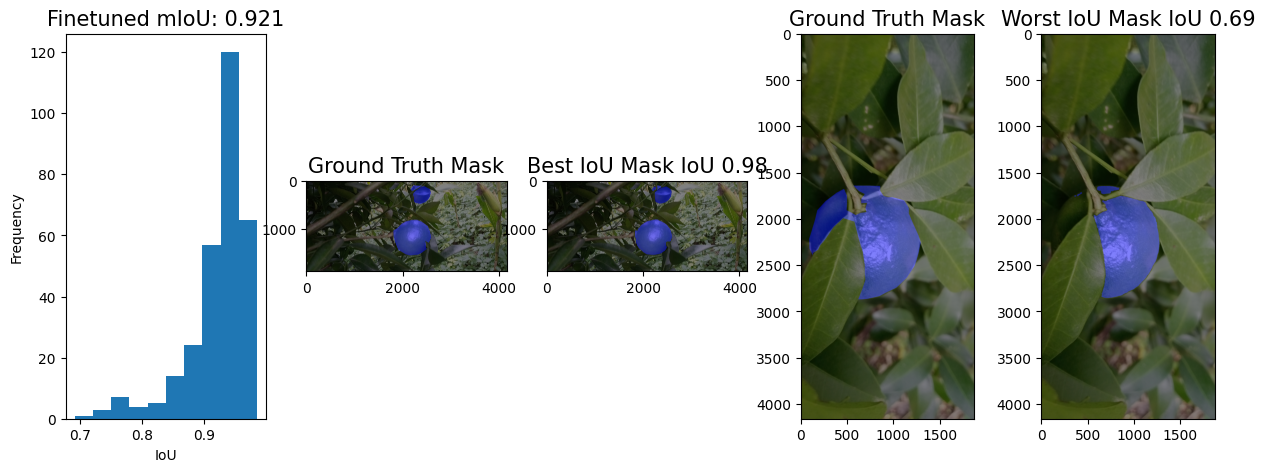

In [13]:
def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
    """
    Overlay a mask on an image.
    """
    # print(mask.shape, image.shape)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 255] = color
    return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
axes[0].set_title('Finetuned mIoU: {:.3f}'.format(mean(epoch_ious)), fontsize=15)
axes[0].set_xlabel('IoU')
axes[0].set_ylabel('Frequency')
axes[0].hist(epoch_ious)
axes[1].imshow(overlay_mask(best_results[0], best_results[1]))
axes[1].set_title('Ground Truth Mask', fontsize=15)
axes[2].imshow(overlay_mask(best_results[0], best_results[2]))
axes[2].set_title(f'Best IoU Mask IoU {best_iou:.2f}', fontsize=15)
axes[3].imshow(overlay_mask(worst_results[0], worst_results[1]))
axes[3].set_title('Ground Truth Mask', fontsize=15)
axes[4].imshow(overlay_mask(worst_results[0], worst_results[2]))
axes[4].set_title(f'Worst IoU Mask IoU {worst_iou:.2f}', fontsize=15)
fig.savefig('finetuned_sam_results.pdf')
plt.show()


0.9419395923614502

## SAM2

^C
ERROR: Operation cancelled by user
